In [366]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, BatchNormalization
from keras.models import Model, load_model 
from keras.utils import get_custom_objects
import keras.backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from IPython.display import display
import pandas as pd
from pandas import DataFrame as DF
import numpy as np
import os
from random import shuffle, randint, sample
from IPython.display import display
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from adjustText import adjust_text
from glob import glob
from urllib.request import urlopen
import json 

pd.set_option('display.max_colwidth', 60)


# load data

In [367]:
path=os.path.join('.','dataset','flight.pickle')
data=pd.read_pickle(path)
data.head(2)

,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
0,208,xxx60133,→,2018-10-11 12:05:00,現在都要拖出來鞭膩,3,42.76.49.49,3,1,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html
1,209,fbiciamib123,推,2018-10-11 12:05:00,抓到了 抵制台獨,3,111.184.160.127,3,1,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html


In [368]:
c=data.push_tag!='→'
data2=data[c]
data2.head(2)

,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
1,209,fbiciamib123,推,2018-10-11 12:05:00,抓到了 抵制台獨,3,111.184.160.127,3,1,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html
7,215,neuralandre,噓,2018-10-11 12:25:00,會酸這種的都9.2跟五毛,3,203.67.101.110,3,0,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html


In [369]:
data3=data2.copy()
data3['label']=data3['label'].map({1:1,0:-1})
data3.head(2)

,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
1,209,fbiciamib123,推,2018-10-11 12:05:00,抓到了 抵制台獨,3,111.184.160.127,3,1,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html
7,215,neuralandre,噓,2018-10-11 12:25:00,會酸這種的都9.2跟五毛,3,203.67.101.110,3,-1,catwalk456,Gossiping,[新聞] 多瑙河畔響起中華民國國歌 長榮機長空姐,2018-10-11 12:04:16,3,125.227.50.235,https://www.ptt.cc/bbs/Gossiping/M.1539230659.A.BBF.html


In [370]:
# df=DF({'a':[1,-5,3],'b':['A','A','B'],'c':['AA','AC','BB']})
# display(df)

# df=df.groupby(['b']).sum().reset_index()
# display(df)


In [371]:
cols=['push_user','article_id','article_user','article_group', 'article_title', 'article_time', 'article_weekday','article_ip', 'article_url']
data4=data3.groupby(cols).sum().reset_index()
data4=data4.sort_values(by='label')

data4.label.max(),data4.label.min()

(14, -25)

In [372]:
bound=5
data4['label_clip']=data4['label'].apply(lambda x: np.clip(x,-bound,bound))
data4.label_clip.max(),data4.label_clip.min()

(5, -5)

In [373]:
data4.head(2)

,push_user,article_id,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url,push_id,push_weekday,label,label_clip
10479,mjj90138,178,necopandora,Gossiping,Re: [新聞] 空姐到公司發現被鎖ID卡變罷工 長榮：,2019-06-24 03:06:06,0,49.215.172.122,https://www.ptt.cc/bbs/Gossiping/M.1561316768.A.BF6.html,314172,2,-25,-5
7757,ilovebingoo,29,seved,Gossiping,[爆卦] 長榮空姐歧視別人，被歧視剛好而已？,2019-01-28 11:19:46,0,49.216.17.55,https://www.ptt.cc/bbs/Gossiping/M.1548645593.A.36B.html,23442,4,-15,-5


In [481]:
all_users=data4[['push_user']].drop_duplicates().reset_index(drop=True)
all_users['user_id']=all_users.index

all_movies=data4[['article_id']].drop_duplicates().reset_index(drop=True)
all_movies['movie_id']=all_movies.index

# all_users.head()
# all_movies.head()
len(all_users),len(all_movies)

(7365, 556)

In [482]:
data5=pd.merge(left=data4,right=all_users,how='inner',on='push_user')
data5=pd.merge(left=data5,right=all_movies,how='inner',on='article_id')

data5.head(2)

,push_user,article_id,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url,push_id,push_weekday,label,label_clip,user_id,movie_id
0,mjj90138,178,necopandora,Gossiping,Re: [新聞] 空姐到公司發現被鎖ID卡變罷工 長榮：,2019-06-24 03:06:06,0,49.215.172.122,https://www.ptt.cc/bbs/Gossiping/M.1561316768.A.BF6.html,314172,2,-25,-5,0,0
1,kuran09,178,necopandora,Gossiping,Re: [新聞] 空姐到公司發現被鎖ID卡變罷工 長榮：,2019-06-24 03:06:06,0,49.215.172.122,https://www.ptt.cc/bbs/Gossiping/M.1561316768.A.BF6.html,139500,0,-12,-5,2,0


In [376]:
data_train, data_valid, _, _ = train_test_split(data5, data5, test_size=0.1, random_state=42)
data_train.shape,data_valid.shape

((14272, 15), (1586, 15))

In [377]:
x_train=[data_train.user_id.values,
         data_train.movie_id.values]
y_train=[data_train.label_clip.values]

x_valid=[data_valid.user_id.values,
         data_valid.movie_id.values]
y_valid=[data_valid.label_clip.values]


In [229]:
def ip2country(ip=''):
    url = 'https://ipinfo.io/%s/json?token=9431775606345c'%(ip)
    res = urlopen(url)
    data = json.load(res)
    country=data['country']
    return country
 
ip='171.98.152.255'
ip2country(ip=ip)

'TH'

# ip

In [628]:
# user2ip
ip_user=data3.push_user.tolist() #+data3.article_user.tolist()
ip=data3.push_ip.tolist() #+data3.article_ip.tolist()
df_ip=DF({'push_user':ip_user,'ip':ip})
df_ip=df_ip.drop_duplicates(subset=['push_user','ip'])
df_ip=df_ip.sort_values(by='push_user').reset_index(drop=True)
df_ip=pd.merge(left=df_ip,right=all_users,on='push_user',how='left')
df_ip.head()

,push_user,ip,user_id
0,A0091127,122.116.59.21,3730
1,A320,no_push_ip,2396
2,A380,no_push_ip,2394
3,A380,223.136.241.185,2394
4,A380,111.71.73.45,2394


In [629]:
# check duplicate ip for different user
df_ip['ip_duplicated']=False
ip_duplicate=df_ip[df_ip.ip!='no_push_ip']
c=ip_duplicate.ip.duplicated()
duplicate_users=ip_duplicate[c].push_user.tolist()
duplicate_users
c=df_ip.push_user.isin(duplicate_users)
df_ip.loc[c,'ip_duplicated']=True
df_ip=df_ip.sort_values(by=['push_user'],ascending=True)

In [630]:
# check multiple ip for one user
multiple_ip=df_ip.groupby(['push_user'])['ip'].count().reset_index()
multiple_ip = multiple_ip.rename(columns={'ip': 'ip_num'})
# multiple_ip.describe()

df_ip=pd.merge(left=df_ip,right=multiple_ip,on='push_user',how='left')
df_ip.head()

,push_user,ip,user_id,ip_duplicated,ip_num
0,A0091127,122.116.59.21,3730,False,1
1,A320,no_push_ip,2396,False,1
2,A380,no_push_ip,2394,False,3
3,A380,223.136.241.185,2394,False,3
4,A380,111.71.73.45,2394,False,3


In [575]:
# df=DF({'a':[1,1,1,3],'b':[4,3,3,6]})
# display(df)

# # c=df.duplicated(subset=['a','b'])
# # display(df[c])

# df.drop_duplicates(subset=['a','b'])


In [518]:
def save_ip(new_ips):
    ip_history=pd.read_csv('ip_history.csv')
    old_ips=ip_history.ip.values
    new_ips_remove_old=[ip for ip in new_ips if ip not in old_ips]
    
    new_countrys=[]
    for i,ip in enumerate(new_ips_remove_old):
        print('----------------')
        print('%s/%s'%(i+1,len(new_ips_remove_old)))
        try:
            country=ip2country(ip=ip)
        except Exception as e:
            print(ip,e)
            country='no_country'
        print(ip,country)
        new_countrys.append(country)
    
    temp=DF({'ip':new_ips_remove_old,'country':new_countrys})
    ip_history=ip_history.append(temp)
    ip_history.to_csv('ip_history.csv', index=False)
    print('new_ips_remove_old =',len(new_ips_remove_old))

# save_ip(new_ips)

In [491]:
def get_dict_ip2country():
    ip_history=pd.read_csv('ip_history.csv').values
    dict_ip2country={row[0]:row[1] for row in ip_history}
    return dict_ip2country

# dict_ip2country=get_dict_ip2country()
# dict_ip2country

# select visualize users

In [416]:
data5.head(2)

,push_user,article_id,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url,push_id,push_weekday,label,label_clip,user_id,movie_id
0,mjj90138,178,necopandora,Gossiping,Re: [新聞] 空姐到公司發現被鎖ID卡變罷工 長榮：,2019-06-24 03:06:06,0,49.215.172.122,https://www.ptt.cc/bbs/Gossiping/M.1561316768.A.BF6.html,314172,2,-25,-5,0,0
1,kuran09,178,necopandora,Gossiping,Re: [新聞] 空姐到公司發現被鎖ID卡變罷工 長榮：,2019-06-24 03:06:06,0,49.215.172.122,https://www.ptt.cc/bbs/Gossiping/M.1561316768.A.BF6.html,139500,0,-12,-5,2,0


In [631]:
c1=data5.push_user=='seved'
c2=data5.article_user=='seved'
c=c1 | c2
select_article_ids=data5[c].article_id.unique()
select_article_ids

array([29, 59])

In [632]:
c=data5.article_id.isin(select_article_ids)
select_df=data5[c]

select_df.head(2)

,push_user,article_id,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url,push_id,push_weekday,label,label_clip,user_id,movie_id
2220,mjj90138,29,seved,Gossiping,[爆卦] 長榮空姐歧視別人，被歧視剛好而已？,2019-01-28 11:19:46,0,49.216.17.55,https://www.ptt.cc/bbs/Gossiping/M.1548645593.A.36B.html,19546,0,10,5,0,1
2221,ilovebingoo,29,seved,Gossiping,[爆卦] 長榮空姐歧視別人，被歧視剛好而已？,2019-01-28 11:19:46,0,49.216.17.55,https://www.ptt.cc/bbs/Gossiping/M.1548645593.A.36B.html,23442,4,-15,-5,1,1


In [633]:
select_users=select_df.push_user.unique()
select_users.shape

(619,)

In [634]:
c=df_ip.push_user.isin(select_users)
df_ip2=df_ip[c].copy()
df_ip2.head()

,push_user,ip,user_id,ip_duplicated,ip_num
1,A320,no_push_ip,2396,False,1
2,A380,no_push_ip,2394,False,3
3,A380,223.136.241.185,2394,False,3
4,A380,111.71.73.45,2394,False,3
19,AKAHOSHI,no_push_ip,2398,False,4


In [635]:
new_ips=df_ip2.ip.unique()
new_ips.shape

(619,)

In [636]:
save_ip(new_ips)

new_ips_remove_old = 0


In [637]:
dict_ip2country=get_dict_ip2country()
len(list(dict_ip2country.keys()))

637

In [638]:
df_ip2['country']=df_ip2['ip'].apply(lambda x: dict_ip2country[x])
df_ip2.head()

,push_user,ip,user_id,ip_duplicated,ip_num,country
1,A320,no_push_ip,2396,False,1,no_country
2,A380,no_push_ip,2394,False,3,no_country
3,A380,223.136.241.185,2394,False,3,TW
4,A380,111.71.73.45,2394,False,3,TW
19,AKAHOSHI,no_push_ip,2398,False,4,no_country


In [640]:
def ip_help(ips):
    for ip in ips:
        if ('no' not in ip) and ('TW' not in ip): return ip
    
    if ('TW' in ips): return 'TW'
    return 'no_country'

# ip_help(['no_country', 'TW','no_country'])

df_ip3=df_ip2.groupby(['push_user','user_id','ip_duplicated','ip_num'])['country'].apply(lambda x: ','.join(x)).reset_index()
df_ip3['country2']=df_ip3['country'].apply(lambda x: x.split(','))
df_ip3['country2']=df_ip3['country2'].apply(lambda x: ip_help(x))
df_ip3.tail()

,push_user,user_id,ip_duplicated,ip_num,country,country2
614,zweibeee,4136,False,1,no_country,no_country
615,zxc61062005,4139,False,2,"TW,no_country",TW
616,zzlostzz,2408,False,1,no_country,no_country
617,zzoohh,2397,False,4,"no_country,TW,JP,TW",JP
618,zzro,2386,False,2,"TW,no_country",TW


# model

In [87]:
def rmse(y_true, y_pred, bound=bound):
    y_pred = K.clip(y_pred, -bound, bound)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

get_custom_objects().update({"rmse": rmse})


# def rmse(y_true, y_pred, bound=2):
#     max_rating=bound*2
#     y_pred = K.clip(y_pred, 0.0, max_rating)
#     return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

# get_custom_objects().update({"rmse": rmse})


In [ ]:
input_length=1
n_movies=len(all_movies)
n_users=len(all_users)
latent_dim=40

user_input = Input(shape=(input_length,))
movie_input = Input(shape=(input_length,))

user_vecter = Embedding(input_dim=n_users, output_dim=latent_dim, input_length=input_length, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)

movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)


rating_predict = dot([user_vecter,movie_vecter],axes=1)

model = Model([user_input,movie_input],rating_predict)

model.compile(loss="mse", optimizer="adam", metrics=[rmse])

model.summary()


In [67]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

early_stopping = EarlyStopping(monitor='val_rmse', mode='min', verbose=1, patience=10, min_delta=0.001)
    
dir_name='flight'
dir_path=os.path.join('.','dataset','weights',dir_name)
make_dir(dir_path)

file_name = 'recommender'
file_name += '-'+"epoch_{epoch:02d}-val_rmse_{val_rmse:.3f}.hdf5"
path=os.path.join(dir_path,file_name)
checkpointer = ModelCheckpoint(filepath=path, verbose=1, monitor='val_rmse', save_best_only=True, mode='min', period=1)


In [ ]:
epochs=50
batch_size=100
history = model.fit(x_train,y_train,
                    validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1, 
                    shuffle=True,
                    callbacks=[early_stopping,checkpointer]
                    )

In [ ]:
plt.figure(figsize=(3,2), dpi=150)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Dense', fontsize=10)
plt.ylabel('RMSE', fontsize=8)
plt.xlabel('epoch', fontsize=8)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# load best model

In [88]:
weights=glob(os.path.join(dir_path,'recommender*')) 
weights.sort()
best_weight=weights[-1]
print(best_weight)
best_nn=load_model(best_weight)

best_nn.summary()

./dataset/weights/flight/recommender-epoch_12-val_rmse_1.074.hdf5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 40)        294600      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 40)        22240       input_6[0][0]                    
___________________________________________

# user embedding

In [89]:
input_ = best_nn.layers[0].input
x = best_nn.layers[2](input_)
output_ = best_nn.layers[4](x)

model_user_embedding = Model(input_, output_)

model_user_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1, 40)             294600    
_________________________________________________________________
flatten_5 (Flatten)          (None, 40)                0         
Total params: 294,600
Trainable params: 294,600
Non-trainable params: 0
_________________________________________________________________


In [90]:
# test=model_user_embedding.predict([n_users-1,n_users-0])
# print(test.shape)
# test

In [91]:
user_vectors=model_user_embedding.predict(all_users.user_id.values)
print(user_vectors.shape)

(7365, 40)


# movie embedding

In [92]:
input_ = best_nn.layers[1].input
x = best_nn.layers[3](input_)
output_ = best_nn.layers[5](x)

model_movie_embedding = Model(input_, output_)

model_movie_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 1, 40)             22240     
_________________________________________________________________
flatten_6 (Flatten)          (None, 40)                0         
Total params: 22,240
Trainable params: 22,240
Non-trainable params: 0
_________________________________________________________________


In [93]:
movie_vectors=model_movie_embedding.predict(all_movies.movie_id.values)
print(movie_vectors.shape)

(556, 40)


# visualize user

In [641]:
df_ip3.head()

,push_user,user_id,ip_duplicated,ip_num,country,country2
0,A320,2396,False,1,no_country,no_country
1,A380,2394,False,3,"no_country,TW,TW",TW
2,AKAHOSHI,2398,False,4,"no_country,TW,TW,TW",TW
3,ALevine,2411,False,1,no_country,no_country
4,AT201010,2384,False,1,no_country,no_country


In [642]:
embedding_select_users=model_user_embedding.predict(df_ip3.user_id)
embedding_select_users.shape

(619, 40)

- tsne

In [643]:
model_tsne = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_select_users = model_tsne.fit_transform(embedding_select_users)
tsne_select_users.shape

(619, 2)

- plot

In [661]:
user = df_ip3.push_user.values
feature = df_ip3.ip_num.values
x = tsne_select_users[:,0]
y = tsne_select_users[:,1]


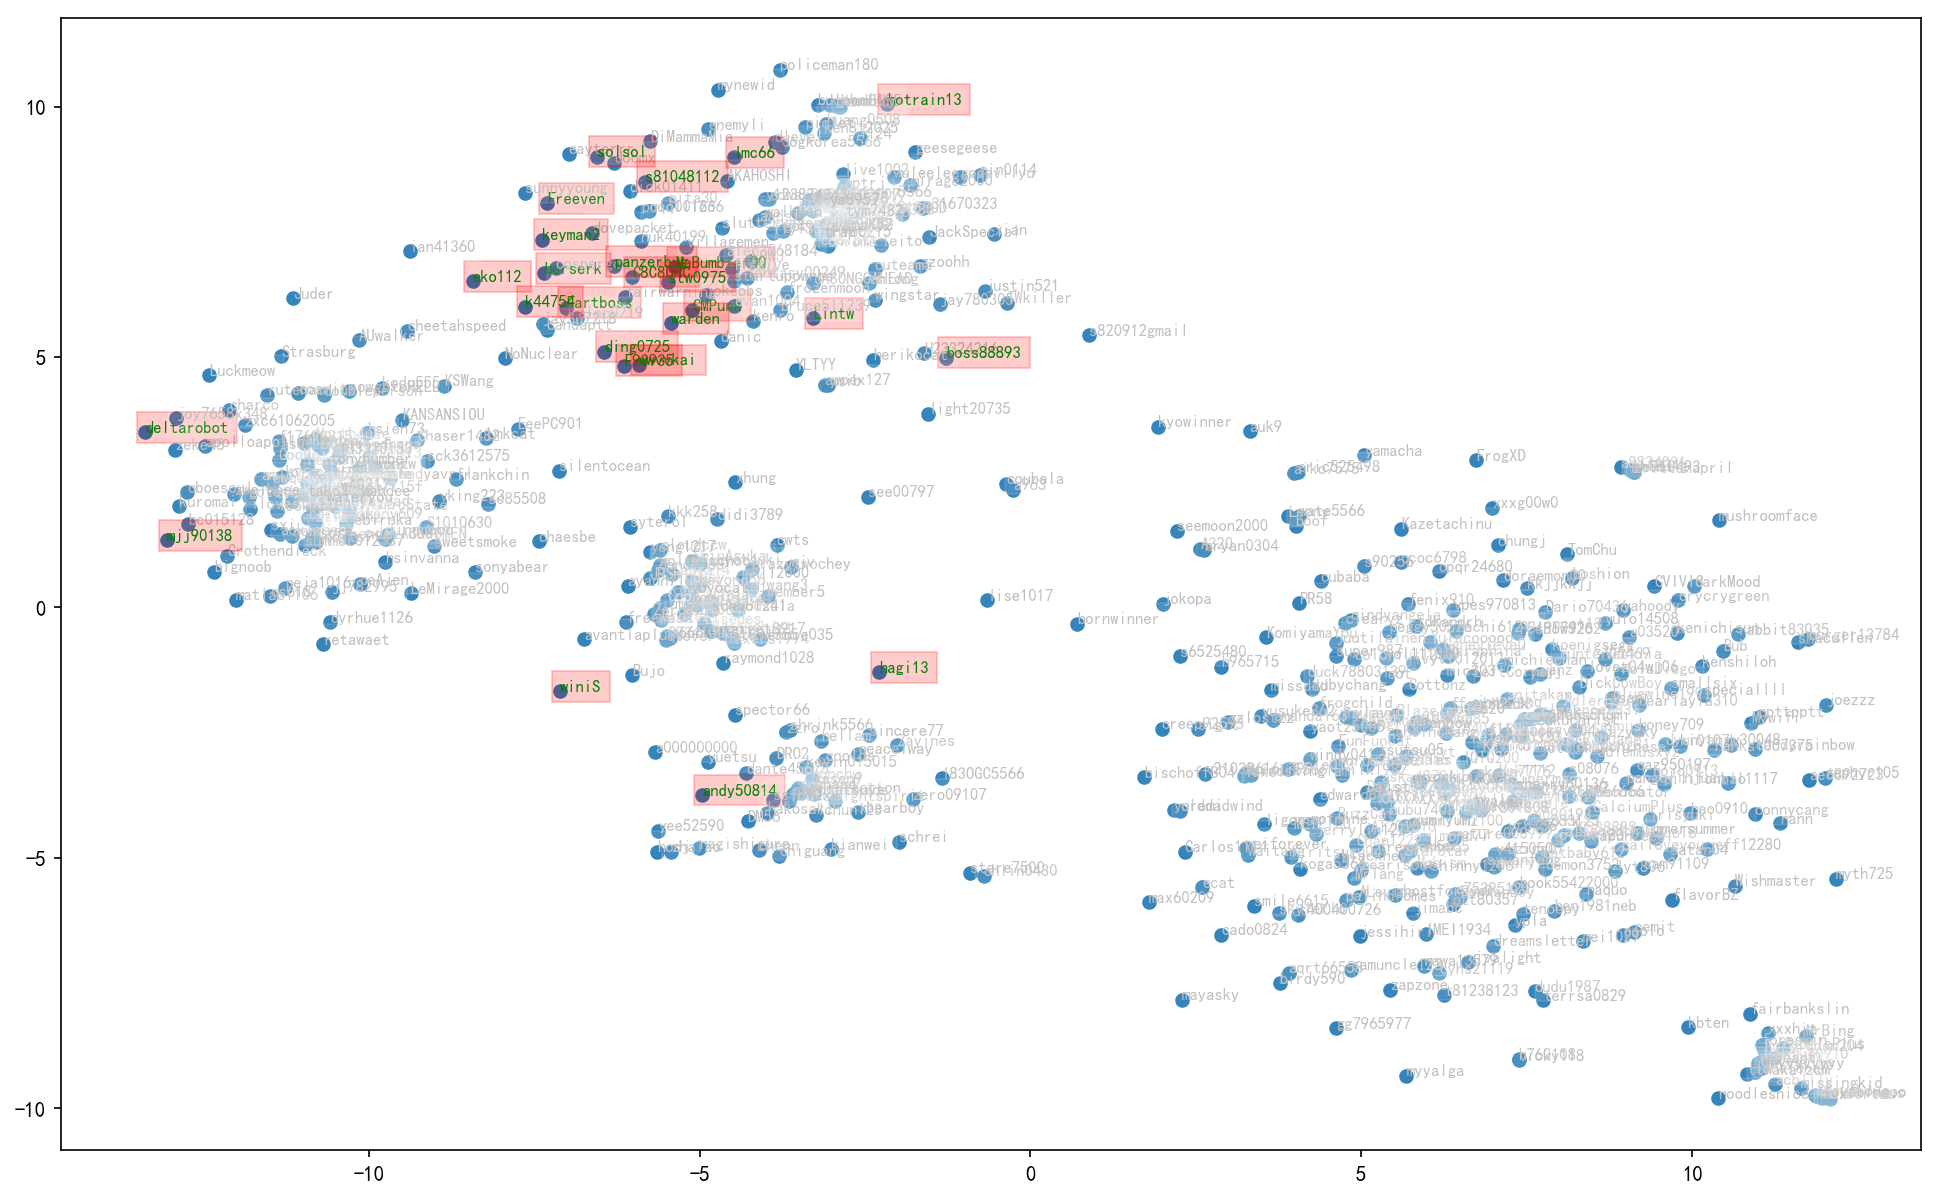

In [664]:
x_y_word = []
plt.figure(figsize=(16*1,10*1),dpi=150)
plt.rcParams['axes.unicode_minus'] = False 

plt.scatter(x,y)

for a, b, c, d in zip(x, y, user, feature):
    
    
    if d>6:
        x_y_word.append(plt.text(a, b, c,fontsize=8,color='green',
                                 bbox=dict(color='red', alpha=0.2))
                       )
    else:
        x_y_word.append(plt.text(a, b, c,fontsize=8,color='silver',
                                 bbox=dict(color='white', alpha=0.1))
                       )
    
#     if d=='TW':
#         x_y_word.append(plt.text(a, b, c,fontsize=8, 
#                                  bbox=dict(color='gray', alpha=0.1))
#                        )
#     elif d=='no_country':
#         x_y_word.append(plt.text(a, b, c,fontsize=8, 
#                                  bbox=dict(color='yellow', alpha=0.1))
#                        )
#     else:
#         x_y_word.append(plt.text(a, b, c,fontsize=8, 
#                                  bbox=dict(color='red', alpha=0.5)))
    
    
#     if d==True:
#         x_y_word.append(plt.text(a, b, c,fontsize=8,color='green',
#                                  bbox=dict(color='red', alpha=0.2))
#                        )
#     else:
#         x_y_word.append(plt.text(a, b, c,fontsize=8,color='silver',
#                                  bbox=dict(color='white', alpha=0.1))
#                        )
    

# adjust_text(x_y_word, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.show()

In [679]:
suspect_user='artbos'
a=df_ip3[df_ip3.push_user.str.contains(suspect_user)]
display(a)
# a=df_ip2[df_ip2.push_user.str.contains(suspect_user)]
# display(a)


# suspect_user='erv'
# a=df_ip3[df_ip3.push_user.str.contains(suspect_user)]
# display(a)
# a=df_ip2[df_ip2.push_user.str.contains(suspect_user)]
# display(a)


c1=data3.push_user.str.contains(suspect_user)
c2=data3.article_id.isin(select_article_ids)
c=c1&c2
display(data3[c])

,push_user,user_id,ip_duplicated,ip_num,country,country2
38,Fartboss,1974,False,8,"TW,TW,TW,TW,TW,no_country,TW,TW",TW


,push_id,push_user,push_tag,push_time,push_content,push_weekday,push_ip,article_id,label,article_user,article_group,article_title,article_time,article_weekday,article_ip,article_url
3178,3386,Fartboss,推,2019-05-28 16:34:00,推備註 空姐吃相難看 被說資方打手我也甘願啦,1,no_push_ip,59,1,seved,Gossiping,[新聞] 防突襲式罷工！長榮暫停彈性排班 空姐,2019-05-28 12:23:24,1,49.215.226.212,https://www.ptt.cc/bbs/Gossiping/M.1559017406.A.79C.html


In [240]:
1/0

ZeroDivisionError: division by zero

# visualize movie 

In [ ]:
model_tsne_movie = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_select_movies = model_tsne_movie.fit_transform(movie_vectors)
tsne_select_movies.shape

In [ ]:
word = all_movies.movie_id.values
x = tsne_select_movies[:,0]
y = tsne_select_movies[:,1]


In [ ]:
x_y_word = []
plt.figure(figsize=(16*1,9*1),dpi=150)
plt.rcParams['axes.unicode_minus'] = False 

plt.scatter(x,y)

for a, b, s in zip(x, y, word):
    
    if s=='shamanlin':
        x_y_word.append(plt.text(a, b, s,fontsize=8, 
                                 bbox=dict(color='red', alpha=0.5)))
    else:
        x_y_word.append(plt.text(a, b, s, 
                                 fontsize=8))
    
# adjust_text(x_y_word, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.show()